# Identifying phishing mails by using URL and mail features and ML based classification tools

## Constructing Dataset

### Importing libraries and defining constants

In [1]:
import os
from bs4 import BeautifulSoup
import mailparser
from collections import OrderedDict
import email
from urllib.request import urlretrieve
import tarfile
import shutil
import numpy as np
import glob
import mailparser
import re 
import tldextract
import urllib.request
import warnings
import logging
import csv
import sys
import logging
import logging.config
import yaml
import pandas as pd
from logging import Formatter
from logging.handlers import RotatingFileHandler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [2]:
warnings.filterwarnings("ignore")
# sns.set_theme()
PUNCTUATIONS= '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

URLREGEX = r"^(https?|ftp)://[^\s/$.?#].[^\s]*$"
URLREGEX_NOT_ALONE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
FLASH_LINKED_CONTENT = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf"
HREFREGEX = '<a\s*href=[\'|"](.*?)[\'"].*?\s*>'
IPREGEX = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))\b"
MALICIOUS_IP_URL = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\/(www|http|https|ftp))\b"
EMAILREGEX = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
GENERAL_SALUTATION = r'\b(dear|hello|Good|Greetings)(?:\W+\w+){0,6}?\W+(user|customer|seller|buyer|account holder)\b'
MAILS_DIR = 'C:/Users/hahah/Documents/NCKH/2023/của Phương/mails'
TAR_DIR = os.path.join(MAILS_DIR, 'tar')
phishing_dir ="C:\\Users\\hahah\\Downloads\\phishingMails"
ham_dir_1 = "C:\\Users\\hahah\\Downloads\\easy_ham_2"
ham_dir_2 = "C:\\Users\\hahah\\Downloads\\hard_ham"


### Downloading and extracting mails (phishing and ham mails)

In [3]:
def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    logger.info("Downloading dataset from '%s'",url)
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)

    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    print(filename)
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
        logger.info("Opened tar '%s'",tarpath)
    except:
        urlretrieve(url, tarpath)
        logger.info("Retrieving from URL '%s'",url)

    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(MAILS_DIR, tar.getnames()[0])
        logger.info("Directory Name '%s'",dirname)
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=MAILS_DIR)

        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)

    return dirname

In [4]:
import logging.config

# Define the logging configuration
config = {
    'version': 1,
    'handlers': {
        'console': {
            'class': 'logging.StreamHandler',
            'level': 'DEBUG',
            'formatter': 'simple',
            'stream': 'ext://sys.stdout'
        }
    },
    'formatters': {
        'simple': {
            'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        }
    },
    'root': {
        'level': 'INFO',
        'handlers': ['console']
    }
}

# Configure logging using the config
logging.config.dictConfig(config)

# Get the logger instance
logger = logging.getLogger('PhishingMailClassifier')

# Log some messages
logger.debug('often makes a very good meal of %s', 'visiting tourists')
logger.info("Project Started\nConstants defined and libraries imported")

# Define other variables as needed
alexa_rank_cache = {}
cache_hit = 0
cache_miss = 0

2023-04-01 23:21:14,284 - PhishingMailClassifier - INFO - Project Started
Constants defined and libraries imported


In [5]:
logging.config.dictConfig(config)
logger = logging.getLogger('PhishingMailClassifier')
logger.debug('often makes a very good meal of %s', 'visiting tourists')
logger.info("Project Started\nConstants defined and libraries imported")
    
alexa_rank_cache = {}
cache_hit = 0
cache_miss = 0

In [6]:
#ham_dir = download_dataset(HAM_URL)
# logger.info("Downloaded Easy Ham Mails")
#hard_ham_dir = download_dataset(HARD_HAM_URL)
# logger.info("Downloaded Hard Ham Mails")
#phishing_dir = download_dataset(PHISHING_URL)
# logger.info("Downloaded Easy Phishing Mails")

### Loading mails

In [7]:
def load_mails(dirpath):
    """load emails from the specified directory"""
    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    logger.info("Loaded mails from '%s'",dirpath)
    return files

In [8]:
# load the datasets

phishing = load_mails(phishing_dir)
print("Number of phishing mails: ",len(phishing))
logger.debug("Number of phishing mails: %d",len(phishing))
ham = load_mails(ham_dir_1)
ham = ham + load_mails(ham_dir_2)
print("Number of ham mails: ",len(ham))
logger.debug("Number of ham mails: %d",len(ham))

Number of phishing mails:  2239
Number of ham mails:  1650


## Data preprocessing and features extraction

#### Dropping duplicates

In [9]:
phishing = list(set(phishing))
ham = list(set(ham))
print("Number of phishing mails ",len(phishing))
print("Number of ham mails ",len(ham))

Number of phishing mails  2239
Number of ham mails  1631


#### UnderSampling 

### Word Cloud Analysis

In [10]:
import mailparser
import email
import datetime

def getMailBody(mail):
    try:
        parsed_mail = mailparser.parse_from_string(mail)
        mail_body = parsed_mail.body.lower()
        subject = parsed_mail.subject
        headers = parsed_mail.headers
        if parsed_mail.date:
            t = parsed_mail.date.timestamp()
            date_utc = datetime.datetime.utcfromtimestamp(t)
        else:
            date_utc = None
    except (UnicodeDecodeError, OSError) as e:
        parsed_mail = email.message_from_string(mail)
        body = ""
        if parsed_mail.is_multipart():
            for part in parsed_mail.walk():
                # returns a bytes object
                payload = part.get_payload(decode=True)
                if payload is None:
                    continue
                strtext = payload.decode(errors='ignore')
                body += strtext
        else:
            payload = parsed_mail.get_payload(decode=True)
            if payload is None:
                return None, None, None
            strtext = payload.decode(errors='ignore')
            body += strtext
        headers = parsed_mail
        mail_body = body.lower()
        subject = headers['Subject']
        date_utc = None
    return [mail_body, subject, headers, date_utc]


In [11]:
#%pip install wordcloud

In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from  nltk.tokenize import word_tokenize
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download()
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import textdistance

  
stop_words = set(stopwords.words('english')) #set of stopwords
 
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def cleanhtml(sentence): #loại bỏ các thẻ HTML
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #loại bỏ các kí tự đặc biệt
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return  cleaned
def filter_words_mail_body(mails): #lọc các từ trong nội dung email
    for mail in mails:
        filtered = []
        filtered_text = cleanpunc(cleanhtml(getMailBody(mail)[0]))
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
        #            w = lemmatizer.lemmatize(w)
                    filtered.append(w)
    return (filtered)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hahah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hahah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hahah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


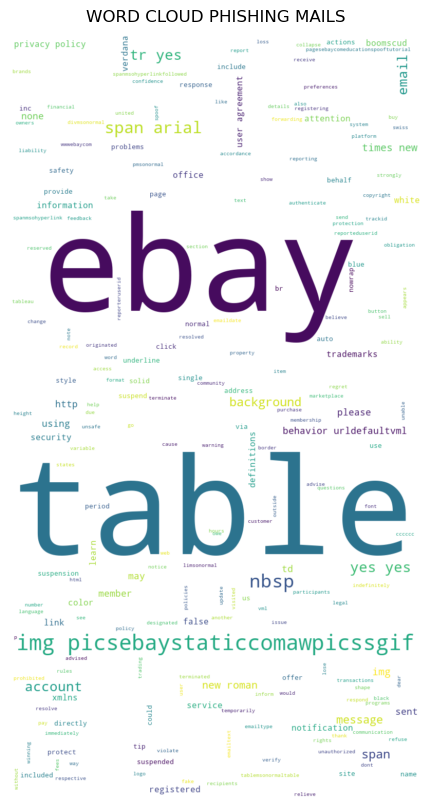

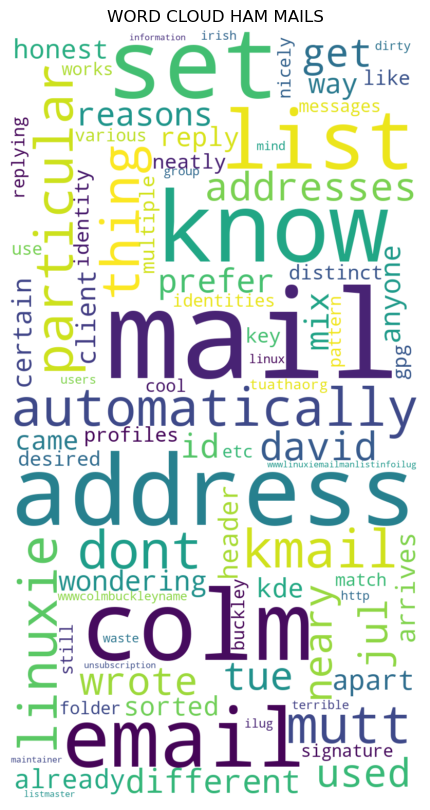

In [13]:
#Visualize words in mail phishing
words_filtered = filter_words_mail_body(phishing)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=stop_words, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD PHISHING MAILS")
plt.show()


words_filtered = filter_words_mail_body(ham)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=stop_words, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD HAM MAILS")
plt.show()


In [14]:
# !pip3 install textdistance

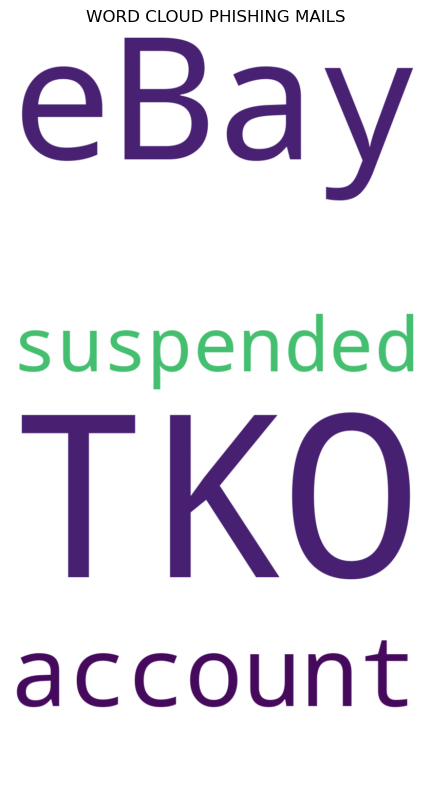

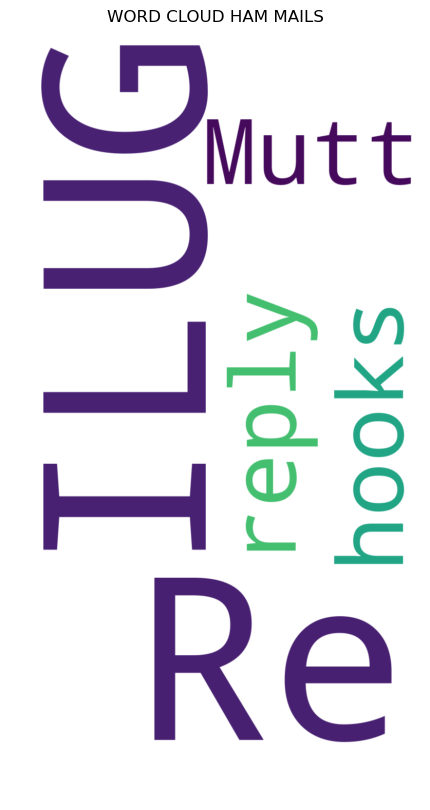

In [15]:
def filter_words_subject(mails):
    for mail in mails:
        filtered = []
        filtered_text = ((getMailBody(mail)[1]))
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
#                     w = lemmatizer.lemmatize(w)
                    filtered.append(w)
    return (filtered)

words_filtered = filter_words_subject(phishing)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=42,stopwords=STOPWORDS, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD PHISHING MAILS")
plt.show()


words_filtered = filter_words_subject(ham)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=42,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD HAM MAILS")
plt.show()

### Mail Features extraction functions

#### Mail body features

In [16]:
def cleanhtml(sentence): #Hàm này được sử dụng để xóa bỏ các thẻ HTML và trả về một chuỗi đã được làm sạch
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): # sử dụng để xóa bỏ các ký tự đặc biệt và dấu câu khỏi câu.
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

 #sử dụng hai hàm trên để làm sạch văn bản của email, tách các từ ra khỏi văn bản và loại bỏ các từ không cần thiết. Nó trả về một danh sách các từ đã được làm sạch.
def cleanBody(mail_body): 
        filtered = []
        filtered_text = cleanpunc(cleanhtml(mail_body))
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
                    filtered.append(w)
        return filtered

def presenceHTML(mail): #trả về 1 nếu email có chứa mã HTML, ngược lại trả về 0.
    msg = email.message_from_string(mail)
    return int((msg.get_content_type() == 'text/html') == True)
  

def presenceHTMLFORM(message):
    return int((re.compile(r'<\s?\/?\s?form\s?>', re.IGNORECASE).search(message)
             != None) == True)


def presenceHTMLIFRAME(message):
    return int(re.compile(r'<\s?\/?\s?iframe\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceJavaScript(message):
    return int(re.compile(r'<\s?\/?\s?script\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceFlashContent(message):
    swflinks = re.compile(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf",
        re.IGNORECASE).findall(message)
    flashObject = re.compile(r'embed\s*src\s*=\s*\".*\.swf\"',
                             re.IGNORECASE).search(message)
    return int((swflinks != None and len(swflinks) > 0) or (flashObject != None)) == True


def presenceGeneralSalutation(message):
    return int(re.compile(GENERAL_SALUTATION,re.IGNORECASE).search(message) != None) == True


def numberOfAttachments(raw_mail):
    try:
        mail = mailparser.parse_from_string(raw_mail)
        count = len(mail.attachments)
        return count
    except:
        return 0

def mail_to(mail_body):
    return int(re.compile(r'mailto:',
                      re.IGNORECASE).search(mail_body) != None) == True

def popups(mail_body): #trả về 1 néu có sự kiện nhấp chuột
    if re.compile(r'window.open|onclick',re.IGNORECASE).search(mail_body):
         return 1
    return 0

# tính toán sự phong phú của nội dung email bằng cách chia số từ trong email cho số lượng từ duy nhất. Trả về giá trị số thực.
def body_richness(mail_body): 
    mail_body = cleanBody(mail_body)
    if len(set(mail_body))!=0:
        return (len(mail_body)/len(set(mail_body)))
    else:
        return len(mail_body)

#### URL features

In [17]:



def isURL(link):
    return re.compile(URLREGEX, re.IGNORECASE).search(link) is not None


def getURLs(mail_body):
    result = []
    cleanPayload = re.sub(r'\s+', ' ', mail_body)
    soup = BeautifulSoup(cleanPayload, 'html.parser')
    links = soup.find_all('a')
    i = 0
    for link in links:
        links[i] = link.get('href')
        i += 1

    for link in links:
        if isinstance(link, str) or isinstance(link, bytes):
            if isURL(link):
                result.append(link)
        else:
            continue

    urlregex = re.compile(URLREGEX_NOT_ALONE, re.IGNORECASE)
    links = urlregex.findall(cleanPayload)

    for link in links:
        if link not in result:
            result.append(link)

    res = list(OrderedDict.fromkeys(result))
    result = list(set(result))
    return result


def IPasURL(urls):
    result = []
    count = 0
    for url in urls:
        if re.compile(IPREGEX, re.IGNORECASE).search(url) and re.compile(IPREGEX, re.IGNORECASE).search(url).group(1) is not None:
            result.append(re.compile(IPREGEX, re.IGNORECASE).search(url).group(1))
            count += 1
    return count


def textLinkDisparity(mail_body):
    count = 0
    soup = BeautifulSoup(mail_body, 'html.parser')
    lists = soup.find_all('a')
    for item in lists:
        link = item.get('href')
        for string in item.stripped_strings:
            text = str(string)
            text = text.strip().replace('\n', '')
            text = text.strip().replace('\t', ' ')
            if isURL(text) and text != link:
                count += 1
    return count


def maliciousURL(urls):
    count = 0
    for url in urls:
        if ((re.compile(IPREGEX, re.IGNORECASE).search(url)
             is not None) == True or (len(re.compile(r'(https?://)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(www.)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(\.com|\.org|\.co)',re.IGNORECASE).findall(url)) > 1))== True:
            count += 1
    return count


def hexadecimalURL(urls):
    count = 0
    for url in urls:
        if ((re.compile(r'%[0-9a-fA-F]+', re.IGNORECASE).search(url)
             is not None) == True):
            count += 1
    return count


def getAlexaRank(domain):
    if domain in alexa_rank_cache:
#         cache_hit +=1
        return int(alexa_rank_cache[domain])
#     else:
#         cache_miss += 1
    try:
        xml = urllib.request.urlopen(
            'http://data.alexa.com/data?cli=10&dat=s&url=%s' %
            domain).read().decode('utf-8')
    except:
        alexa_rank_cache[domain] = 0
        return 0
    try:
        rank = (re.compile(r'RANK="(\d+)"',re.IGNORECASE).findall(xml))[1]
    except:
        rank = -1
    alexa_rank_cache[domain] = rank
    return int(rank)


def extractDomains(urls):
    domain_set = set()
    for url in urls:
        domain = tldextract.extract(url).registered_domain
        if domain not in domain_set:
            domain_set.add(domain)
        else:
            continue

    return list(domain_set)


def domainCounts(url):
    domains = tldextract.extract(url)
    count = (len(re.compile(r'\.',re.IGNORECASE).findall( domains.subdomain))) + \
        ((len(re.compile(r'\.',re.IGNORECASE).findall( domains.domain)))+1)
    if re.compile(IPREGEX,re.IGNORECASE).search(domains.domain) is not None:
        count -= 3
    return (count)


def presenceBadRankedURL(urls):
    domains = extractDomains(urls)
    max_rank = 0
    for domain in domains:
        rank = getAlexaRank(domain)
        max_rank = max(rank, max_rank)
        if rank == -1:
            return 0
    if max_rank > 70000:
        return 1
    return 0

def maxDomainsCounts(urls):
    count = 1
    for url in urls:
        count = max(domainCounts(url), count)
    return count

def at_in_url(urls):
    for url in urls:
        if (re.compile(r'@',re.IGNORECASE).search(url)):
            return 1
        else: 
            continue
    return 0
import json
import ast
def writeCache():
    with open('./cache/alexa_rank_cache.txt', 'w') as cache_file:
        cache_file.write(json.dumps(alexa_rank_cache))
        logger.info("Cache written")
        

def loadCache():
    try:
        with open('./cache/alexa_rank_cache.txt','r') as cache_file:
            cache = ast.literal_eval(cache_file.read())
            alexa_rank_cache = cache
            logger.info("Cache loaded")
    except FileNotFoundError:
        log.warning("No alexa rank cache found")


#### Subject line features

In [18]:


def isRepliedMail(subject):
    return (subject).startswith('Re:')

def isForwardedMail(subject):
    return (subject).startswith('Fwd:')

def subject_richness(subject):
    texts = subject.split()
    if len(set(texts))!=0:
        return (len(texts)/len(set(texts)))
    else:
        return len(texts)
def contains_verify(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (jaro('verify',w)) >0.9:
            return 1
     return 0

def contains_update(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (jaro('update',w)) >0.9:
            return 1
     return 0

def contains_access(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (jaro('access',w)) >0.9:
            return 1
     return 0
# def get_top_n_words(corpus, n=None):
#     filtered = []
#     for word in corpus:
#         word = stemmer.stem(word)
#         word = lemmatizer.lemmatize(word)
#         filtered+=word
#     corpus = set(filtered)
#     vec = CountVectorizer().fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]

# body = ""
# for mail in phishing:
#     body += getMailBody(mail)[0]
#     body+=" "
# print(get_top_n_words(body))
def contains_prime_targets(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if ((jaro('bank',w)) >0.9 or (jaro('Paypal',w)) >0.9 or (jaro('ebay',w)) >0.9 or (jaro('amazon',w)) >0.9):
            return 1
     return 0

def contains_account(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (jaro('account',w)) >0.9 or jaro('profile',w) >0.9 or jaro('handle',w) >0.9 :
            return 1
     return 0
    
def contains_suspended(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (((jaro('closed',w)) or jaro('expiration',w))or jaro('suspended',w)) >0.9 or jaro('terminate',w) >0.9 or jaro('restricted',w) >0.9:
            return 1
     return 0

def contains_password(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():
         
         if (jaro('password',w)) >0.9 or jaro('credential',w) > 0.9:
            return 1
     return 0

def contains_urgent(subject):
    subject = purify(subject)
    jaro = textdistance.Jaro()
    for w in subject.split():
        if (jaro('urgent',w)) >0.9 or jaro('immediate',w) >0.9:
           return 1
    return 0

def purify(subject):
    filtered = ""
    word_tokens = word_tokenize(subject)
    for w in word_tokens:
         if w not in stop_words and w.isalpha():
                   w = stemmer.stem(w)
                   filtered+=(lemmatizer.lemmatize(w))
                   filtered+=" "
    return filtered


#### Sender's address features

In [19]:
def number_of_dots(headers):
    try:
        sender = headers.get("From", "")
        return len(re.compile(r'\.',re.IGNORECASE).findall(sender))
    except KeyError as Argument:
        return 0
def number_of_dash(headers):
    try:
        subject = headers.get("Subject", "")
        return len(re.compile(r'\-',re.IGNORECASE).findall(subject))
    except KeyError as Argument:
        return 0
   


### Constructing dataset by extracting features

In [20]:
filename = "./dataset/mails_dataset.csv"
fields = [
     "HTML", "HTMLForm", "IFrame", "FlashContent", "General Salutation",
    "Javascript", "mailto:","popups","body richness","Number of URLs", "Malicious URL", "text link disparity",
    "Attachments", "IP URLs", "hexadecimal URL", "Bad Rank Domain",
    "Maximum Domains Counts","@_in_url","Subject richness","Fwd: mail","Re: mail","contains account","contains verify",
    "contains update","contains prime targets","contains suspension","contains password","contains urgent","contains access",
    "number of dots","number of dash","Class"
]
rows = []

def constructDataSet(messages, label):
    i = 1
    
    for mail in messages:
        parsed_mail = getMailBody(mail)
        
        mail_body = parsed_mail[0]
        mail_subject = parsed_mail[1]
        mail_headers = parsed_mail[2]

        
        urls = getURLs(mail_body)
        feature = [0] * (len(fields))
        i = 0
        feature[i]= int(presenceHTML(mail)==True)
        i+=1
        feature[i]= int(presenceHTMLFORM(mail_body)==True)
        i+=1
        feature[i]= int(presenceHTMLIFRAME(mail_body)==True)
        i+=1
        feature[i]= int(presenceFlashContent(mail_body)==True)
        i+=1
        feature[i]= int(presenceGeneralSalutation(mail_body)==True)
        i+=1
        feature[i]= int(presenceJavaScript(mail_body)==True)
        i+=1
        feature[i]= int(mail_to(mail_body)==True)
        i+=1
        feature[i]= popups(mail_body)
        i+=1
        feature[i] = body_richness(mail_body)
        i+=1
        feature[i]= len(urls)
        i+=1
        feature[i]= (maliciousURL(urls))
        i+=1
        feature[i]= textLinkDisparity(mail_body)
        i+=1
        feature[i] = numberOfAttachments(mail)
        i+=1
        feature[i] = (IPasURL(urls))
        i+=1
        feature[i] = (hexadecimalURL(urls))
        i+=1
        feature[i] = int(presenceBadRankedURL(urls)==True)
        i+=1
        feature[i] = (maxDomainsCounts(urls))
        i+=1
        feature[i]= at_in_url(urls)
        i+=1
        feature[i] = subject_richness(mail_subject)
        i+=1
        feature[i]= int(isForwardedMail(mail_subject)==True)
        i+=1
        feature[i]= int(isRepliedMail(mail_subject)==True)
        i+=1
        feature[i]= int(contains_account(mail_subject)== True)
        i+=1
        feature[i]= int(contains_verify(mail_subject)==True)
        i+=1
        feature[i]= int(contains_update(mail_subject)==True)
        i+=1
        feature[i]= int(contains_prime_targets(mail_subject)==True)
        i+=1
        feature[i]= int(contains_suspended(mail_subject)==True)
        i+=1
        feature[i]= int(contains_password(mail_subject)==True)
        i+=1
        feature[i]= int(contains_urgent(mail_subject)==True)
        i+=1
        feature[i] = int(contains_access(mail_subject)==True)
        i+=1
        feature[i]= number_of_dots(mail_headers)
        i+=1
        feature[i]= number_of_dash(mail_headers)
        i+=1
        feature[i] = label
        rows.append(feature)


In [21]:
def constructDataSet_nlp_feature(messages, label):
    i = 1
    
    for mail in messages:
        parsed_mail = getMailBody(mail)
        
        mail_body = parsed_mail[0]
        mail_subject = parsed_mail[1]
        mail_headers = parsed_mail[2]

In [22]:
def writeCSV():
    with open(filename, 'w', newline='') as csvfile:
        
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)

        # writing the fields
        csvwriter.writerow(fields)

        # writing the data rows
        csvwriter.writerows(rows)
        #logger.info("CSV written to %s",filename)
        print("written CSV")

In [23]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hahah\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
rows.clear()
#loadCache()
logger.debug("Started Constructing Dataset for Ham mail")
print("HAM MAILS")
constructDataSet(ham, "Ham")
print(rows)
print("PHISHING MAILS")
logger.debug("Started Constructing Dataset for Phishing mail")
constructDataSet(phishing, "Phishing")
writeCSV()
writeCache()

HAM MAILS
[[0, 0, 0, 0, 0, 0, 0, 0, 1.0975609756097562, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.4814814814814814, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.2666666666666666, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.3548387096774193, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.4137931034482758, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.1891891891891893, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.3270142180094786, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0, 0, 1.4193548387096775, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1.0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 'Ham'], [0, 0, 0, 0, 0, 0, 0,

In [26]:
mails = pd.read_csv("./dataset/mails_dataset.csv")
#mails = mails.drop_duplicates()
print("Number of Ham class records: ",len(mails[mails['Class'] == 'Ham']))
print("Number of Phishing class records: ",len(mails[mails['Class'] == 'Phishing']))

Number of Ham class records:  1631
Number of Phishing class records:  2239


## Split Training and Testing data

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()
mails = pd.read_csv("./dataset/mails_dataset.csv")

labels=le.fit_transform(mails['Class'])

mails.drop('Class',axis =1,inplace=True)



X_train, X_test, Y_train, Y_test = train_test_split(mails,
                                                    labels,
                                                    test_size=0.20,
                                                    stratify=labels,
                                                    random_state=42)
# check dataset shapes
print(X_train.shape, (Y_train).shape)


(3096, 31) (3096,)


## Exploratory Data Analysis

### Checking dataset 

In [28]:
mails = X_train.copy(deep=True)
mails['Class'] =  pd.Series(Y_train, index=mails.index)

mails.describe()

,HTML,HTMLForm,IFrame,FlashContent,General Salutation,Javascript,mailto:,popups,body richness,Number of URLs,...,contains verify,contains update,contains prime targets,contains suspension,contains password,contains urgent,contains access,number of dots,number of dash,Class
count,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,...,3096.000000,3096.000000,3096.000000,3096.000000,3096.00000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000
mean,0.319444,0.037791,0.015181,0.001292,0.117248,0.040052,0.059109,0.043605,1.583652,8.556525,...,0.010982,0.066860,0.204457,0.000646,0.00323,0.026163,0.045866,1.651486,0.322351,0.578488
std,0.466337,0.190721,0.122292,0.035927,0.321768,0.196112,0.235866,0.204247,0.667509,58.019717,...,0.104234,0.249821,0.403370,0.025412,0.05675,0.159645,0.209227,0.968478,0.657084,0.493881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.225806,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.414634,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.702313,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.057143,3117.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,9.000000,7.000000,1.000000


In [29]:
#checking for missing values
# print(mails.isnull().sum())
mails.drop_duplicates(keep = "first", inplace = True)
print("Number of Ham class records: ",len(mails[mails['Class'] == 0]))
print("Number of Phishing class records: ",len(mails[mails['Class'] == 1]))
labels = mails['Class']
mails.drop('Class',axis=1,inplace=True)
mails.tail()

Number of Ham class records:  1258
Number of Phishing class records:  1486


,HTML,HTMLForm,IFrame,FlashContent,General Salutation,Javascript,mailto:,popups,body richness,Number of URLs,...,contains account,contains verify,contains update,contains prime targets,contains suspension,contains password,contains urgent,contains access,number of dots,number of dash
494,0,0,0,0,0,0,0,0,1.363636,1,...,0,0,0,0,0,0,0,0,1,0
22,1,1,0,0,0,0,0,0,1.747051,107,...,0,0,0,0,0,0,0,0,1,0
1810,1,0,0,0,1,0,0,0,1.363636,2,...,1,1,0,1,0,0,0,0,2,0
2381,1,0,0,0,0,0,0,0,1.670886,4,...,0,0,0,0,0,1,0,0,2,0
2833,0,0,0,0,1,0,0,0,1.403846,2,...,1,0,0,0,0,0,0,1,3,0


### Heatmap

<AxesSubplot:>

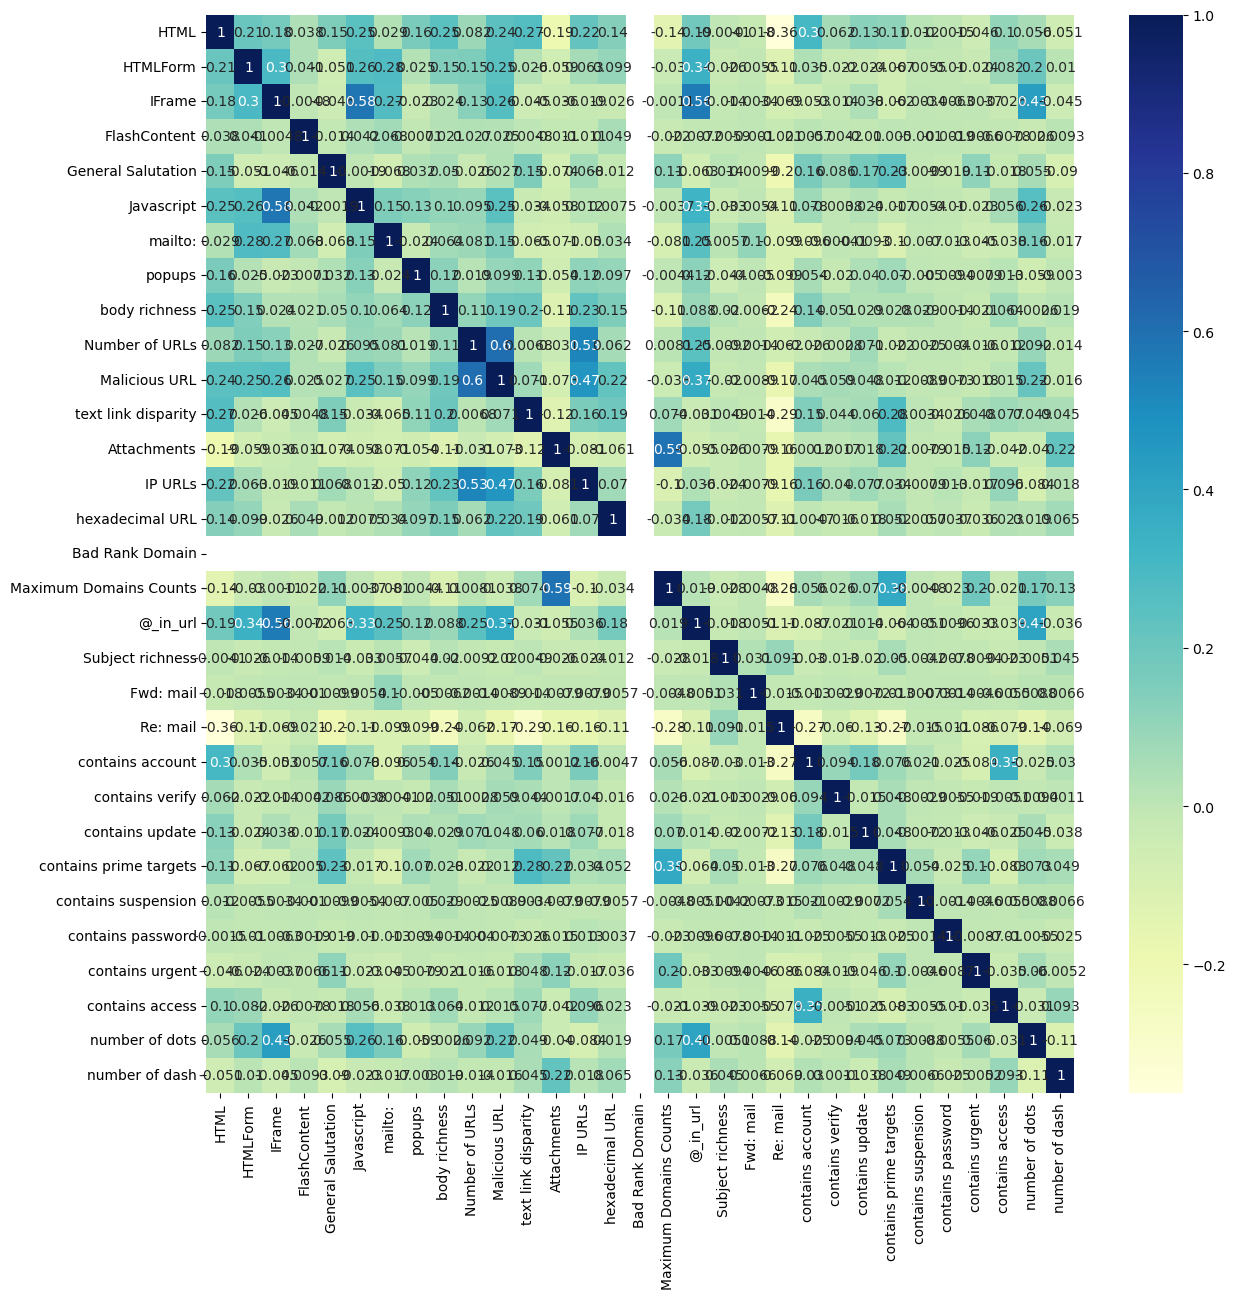

In [30]:
%matplotlib inline
plt.figure(figsize = (14,14))
sns.heatmap(mails.corr(),annot=True,cmap="YlGnBu")


As I can interpret from the heatmap shown in Figure 12, there is no such very strong correlation between features but I have decent correlation between:
- JavaScript and Iframe
- Iframe and @_in_url
- Text link disparity and maximum domains counts
- IP URLs and Number of URLs
- Malicious URL and Number of URLs <br>
These correlations are quite obvious trend revealed in the heatmap. As number of URLs increases the mail tend to be more malicious and have IP URLs. It also reveals that if a mail has many domains it is much likely to have text link disparity.

### Visualization: Matplotlib

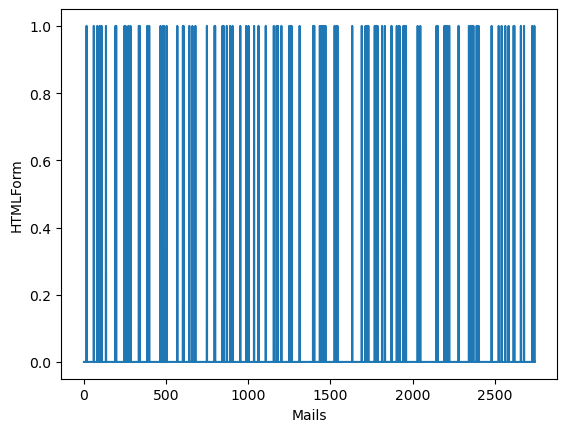

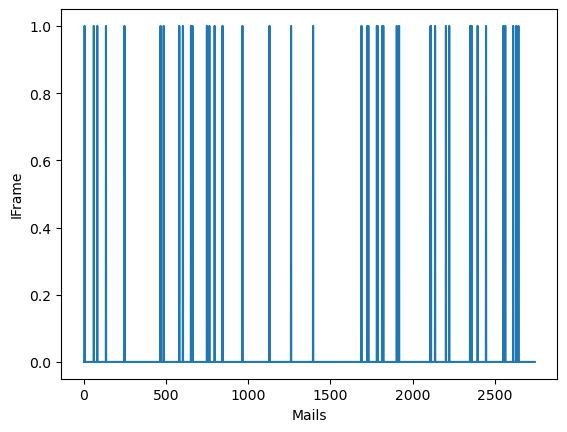

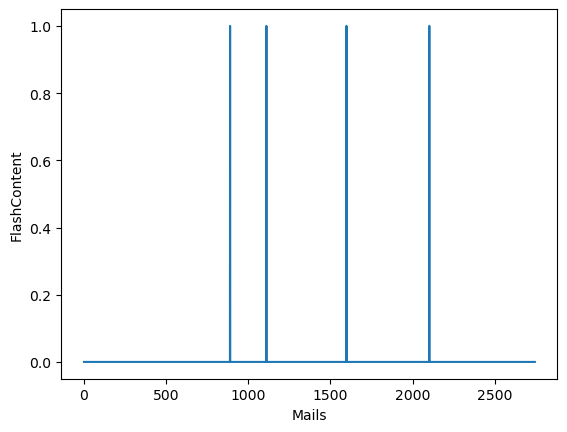

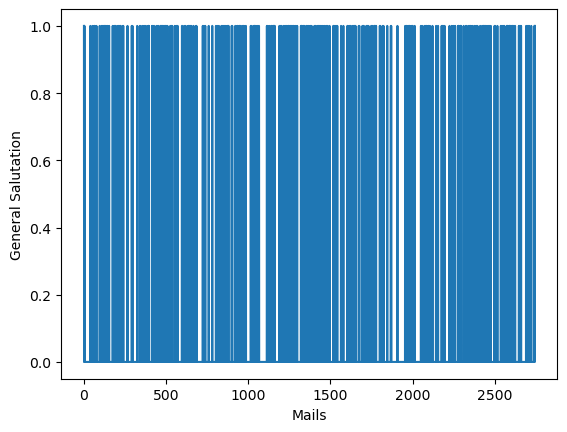

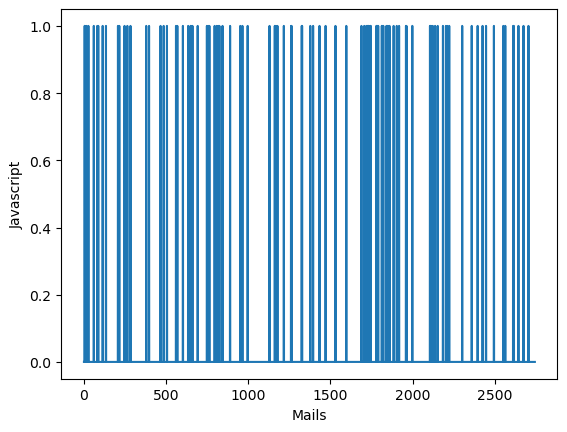

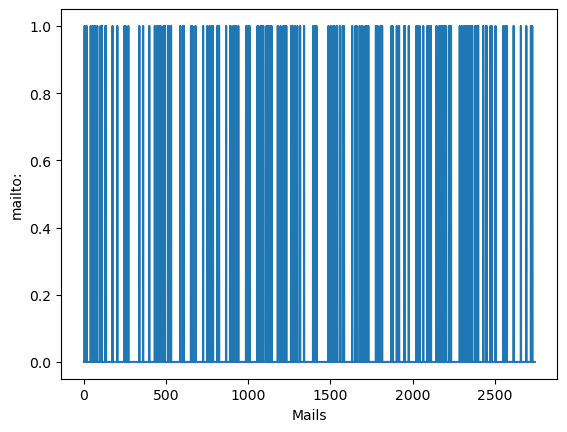

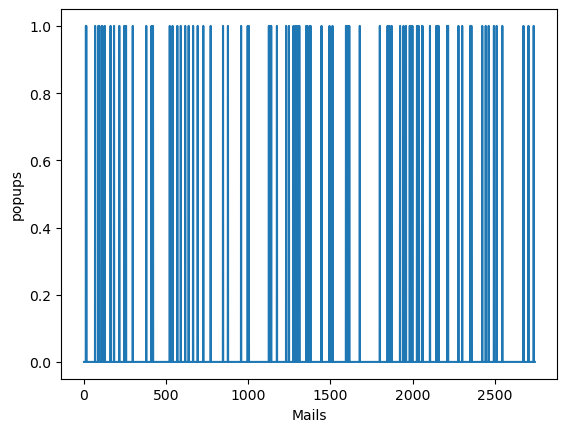

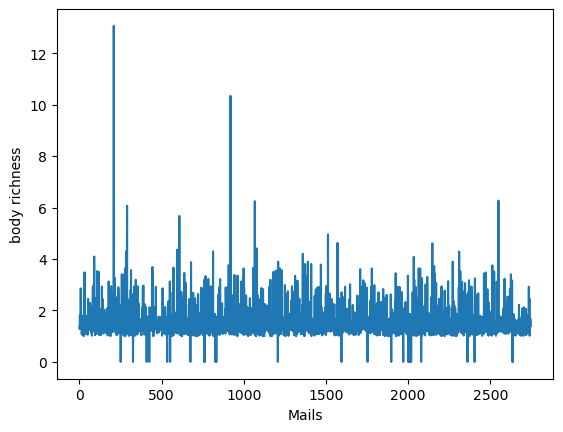

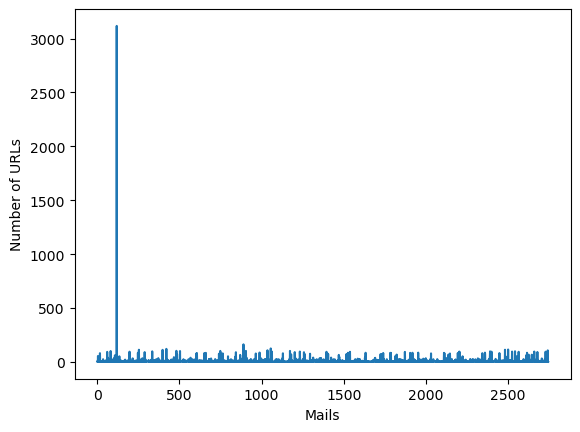

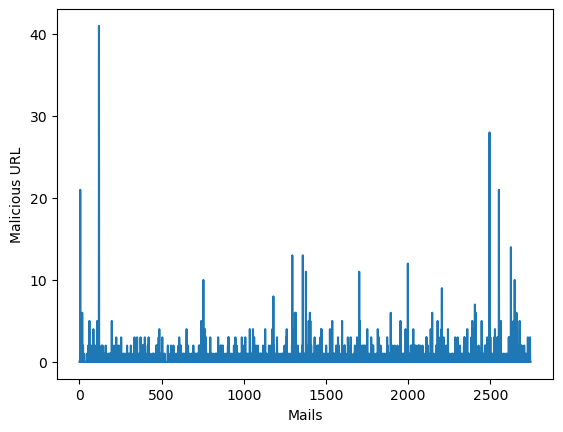

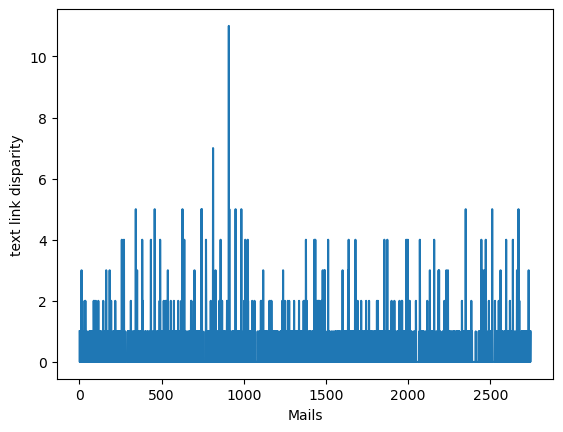

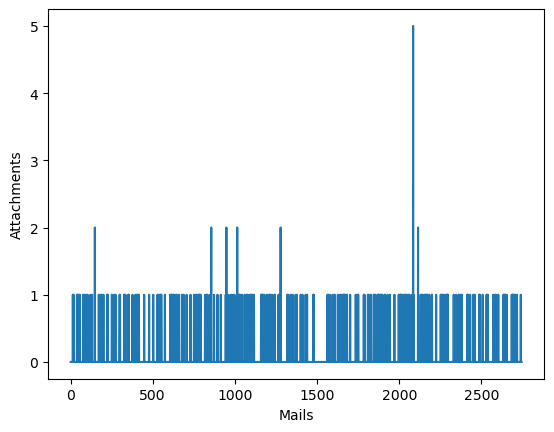

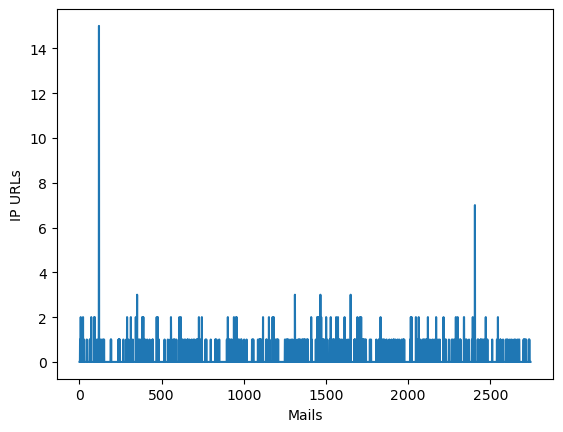

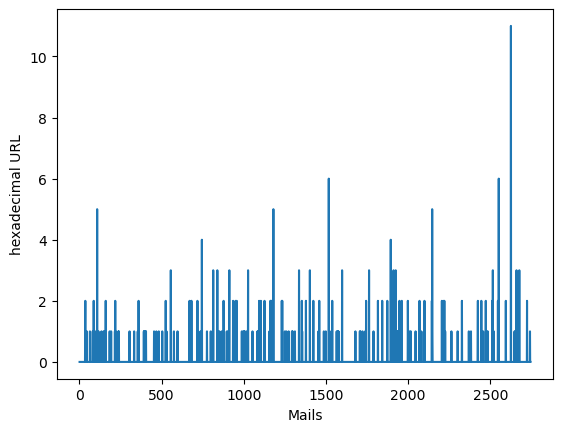

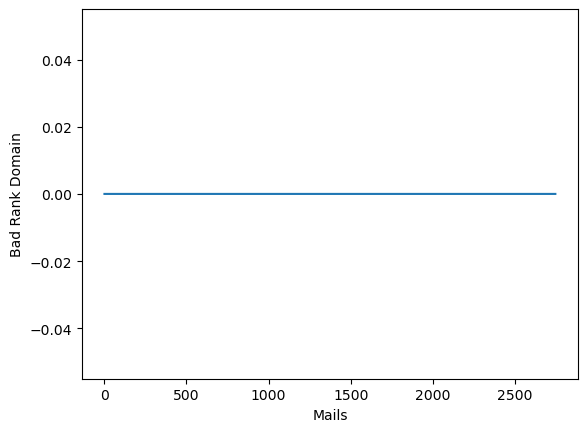

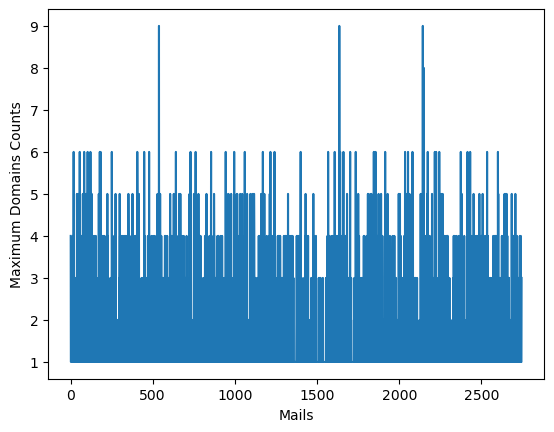

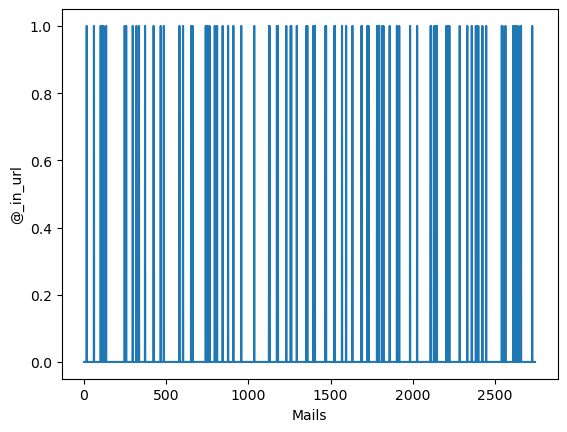

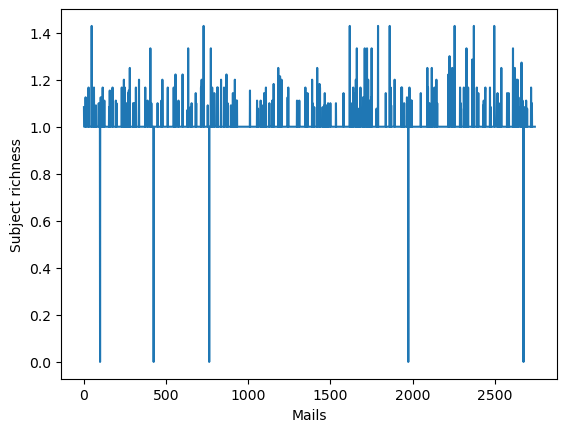

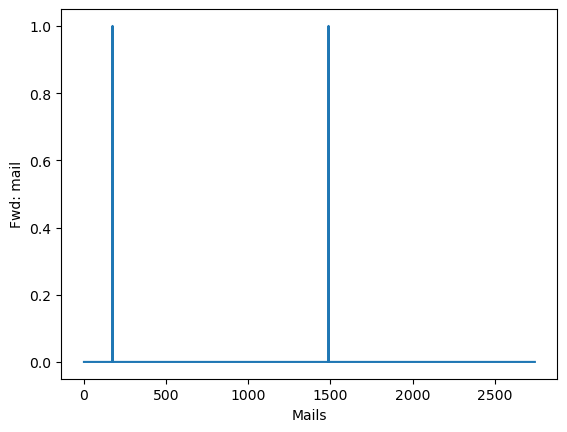

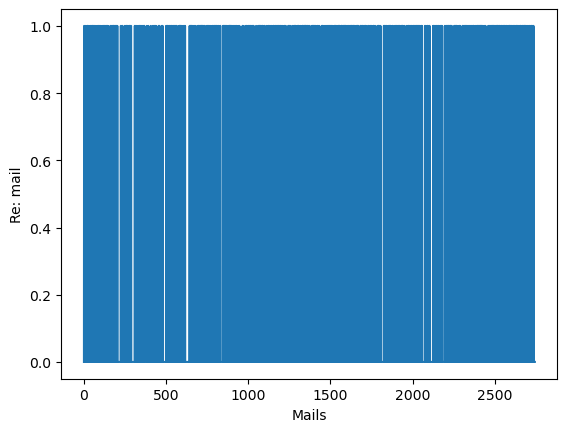

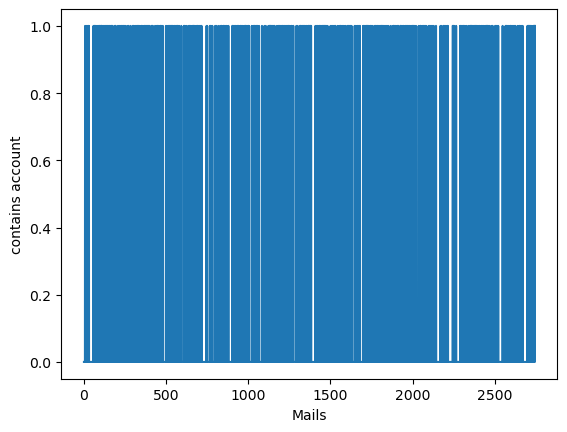

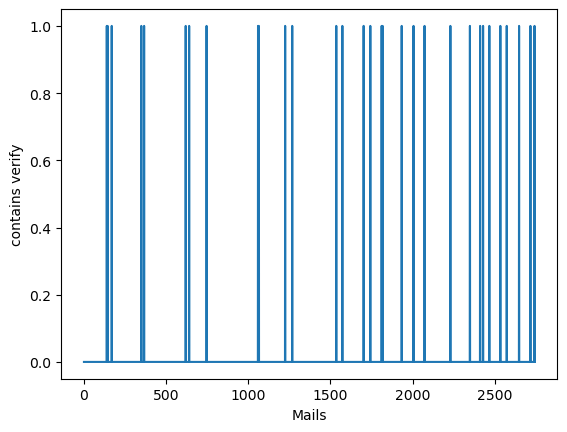

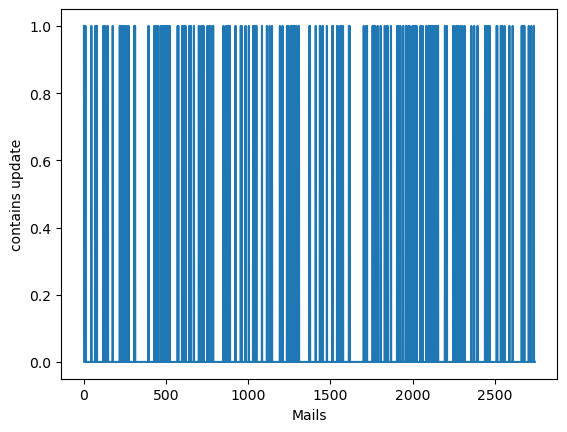

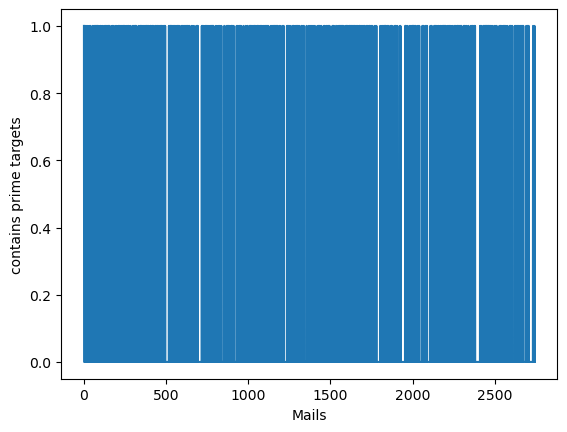

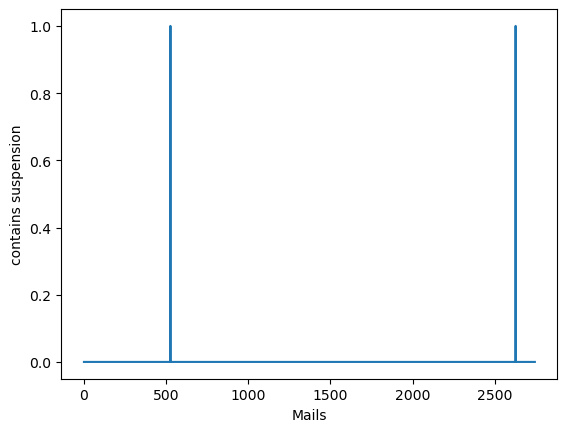

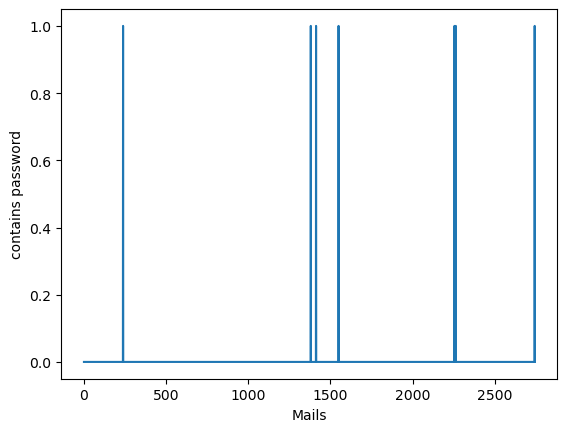

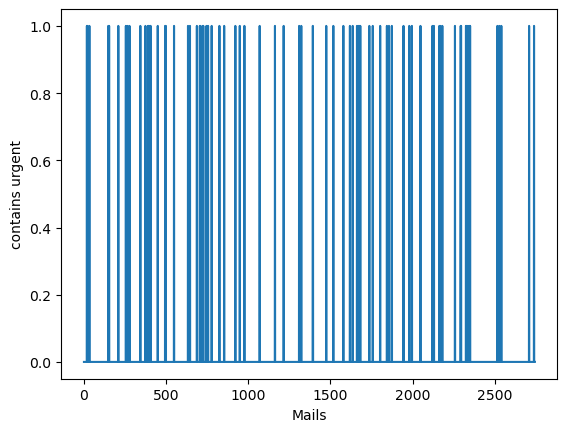

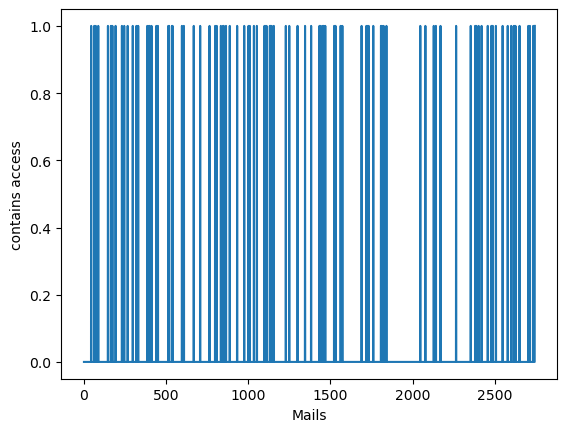

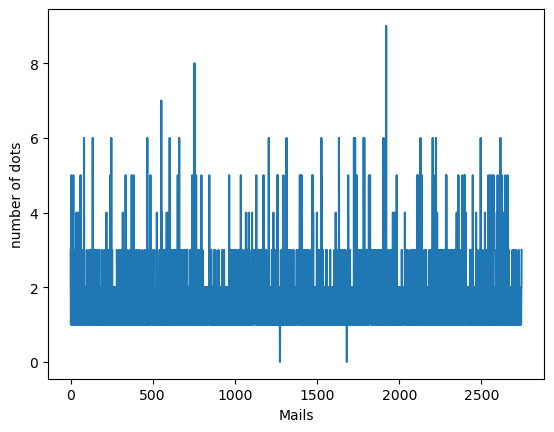

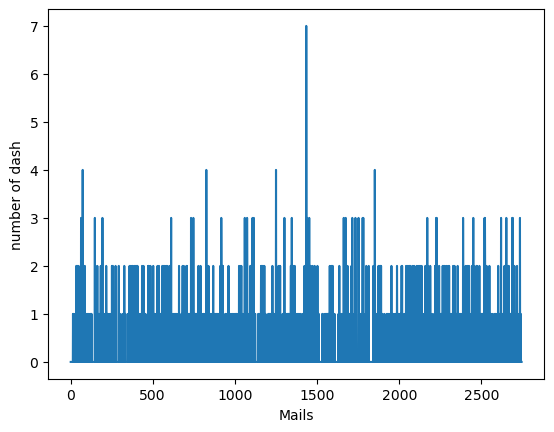

In [31]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_data():
        feature_val = np.array(mails).T
        fields = mails.columns
        xpoints = np.arange(1,len(mails)+1,1)
        for i in range(1,len(fields),1):
            ypoints = np.array(feature_val[i])
            plt.ylabel(fields[i]) 
            
            plt.xlabel("Mails")
            plt.plot(xpoints, ypoints)
            plt.show()
        
visualize_data()
#logger.debug("Matplotlib visualization done")

### Feature Selection

In [32]:
## Remove features with missing values
X_train.isnull().any().any()

False

#### Variance Filter

In [33]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.16))
sel.fit(X_train)
cols = sel.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
Selected_features_VarianceFilter = features_df_new.columns
Selected_features_VarianceFilter

Index(['HTML', 'body richness', 'Number of URLs', 'Malicious URL',
       'text link disparity', 'IP URLs', 'hexadecimal URL',
       'Maximum Domains Counts', 'Re: mail', 'contains account',
       'contains prime targets', 'number of dots', 'number of dash'],
      dtype='object')

In [34]:
Filtered = X_train[Selected_features_VarianceFilter]

#### Feature Importance with Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
X_trainn = Filtered
model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_trainn,Y_train)

RandomForestClassifier(max_depth=10, random_state=42)

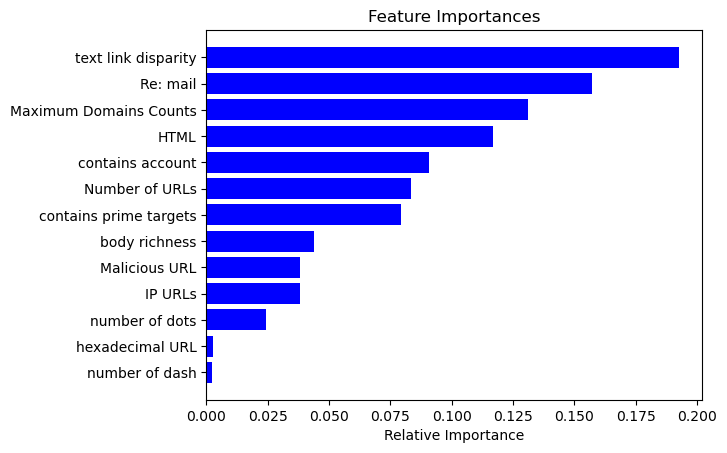

['text link disparity',
 'Re: mail',
 'Maximum Domains Counts',
 'HTML',
 'contains account',
 'Number of URLs',
 'contains prime targets',
 'body richness',
 'Malicious URL',
 'IP URLs',
 'number of dots',
 'hexadecimal URL',
 'number of dash']

In [36]:
features = X_trainn.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-13:]  # top 10 features

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

Selected_features_RandomForestClassifier = [features[index] for index in indices]
Selected_features_RandomForestClassifier.reverse()
Selected_features_RandomForestClassifier

#### Univariate using SelectKBest

In [37]:
#UNIVARIATE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = X_train, Y_train
selector = SelectKBest(chi2, k=11)
selector.fit(X,y)
# sel.scores_
cols = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
Selected_features_Univariate = features_df_new.columns
Selected_features_Univariate 

Index(['HTML', 'General Salutation', 'mailto:', 'Number of URLs',
       'text link disparity', 'Attachments', 'IP URLs',
       'Maximum Domains Counts', 'Re: mail', 'contains account',
       'contains prime targets'],
      dtype='object')

UNION ALL SELECTED CANDIDATES

In [38]:
# Selected_features = ((Selected_features_RandomForestClassifier + Selected_features_Univariate) + Selected_features_VarianceFilter)
# # len(set(Selected_features))
Selected_features = []
Selected_features.extend(Selected_features_RandomForestClassifier) 
Selected_features.extend(Selected_features_Univariate)
Selected_features.extend(Selected_features_VarianceFilter)
Selected_features = set(Selected_features)
Selected_features

{'Attachments',
 'General Salutation',
 'HTML',
 'IP URLs',
 'Malicious URL',
 'Maximum Domains Counts',
 'Number of URLs',
 'Re: mail',
 'body richness',
 'contains account',
 'contains prime targets',
 'hexadecimal URL',
 'mailto:',
 'number of dash',
 'number of dots',
 'text link disparity'}

#### High Correlation Filter

<AxesSubplot:>

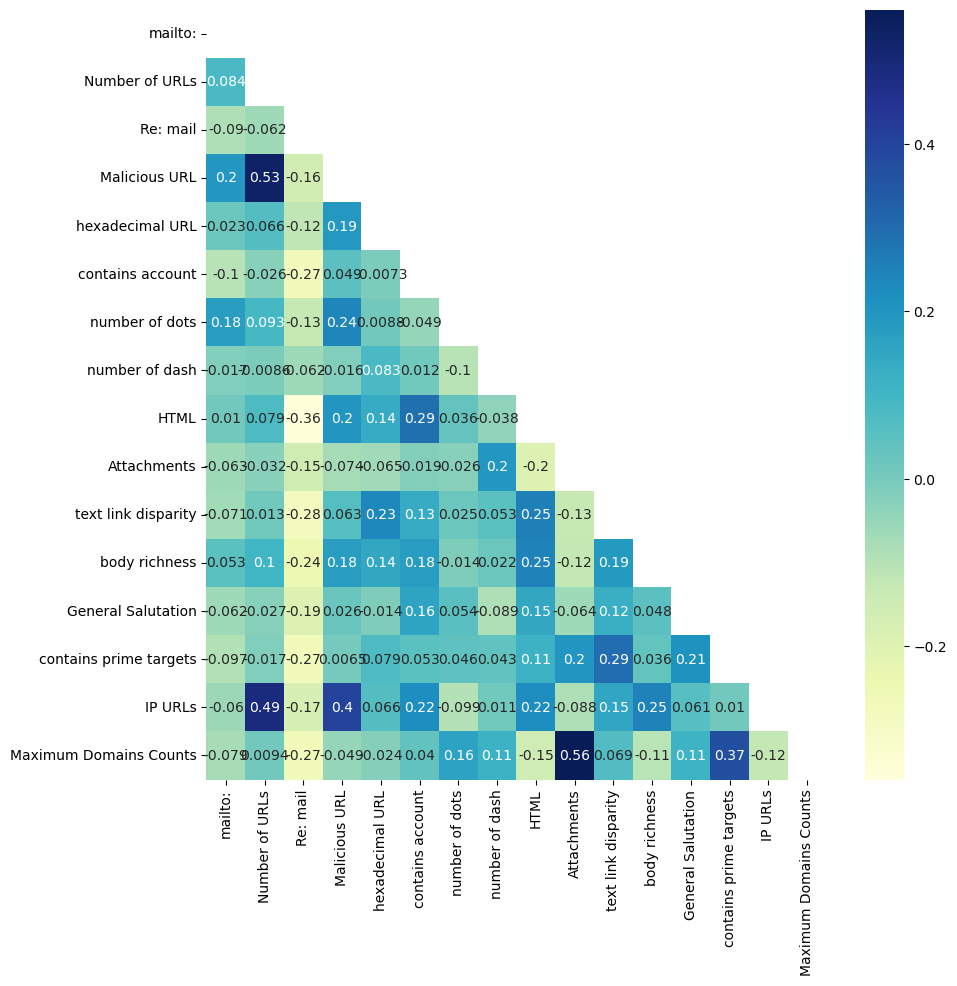

In [39]:
Filtered = X_train[Selected_features]
plt.figure(figsize = (10,10))
# creating mask
mask = np.triu(np.ones_like(Filtered.corr()))
  

sns.heatmap(Filtered.corr(),annot=True,cmap="YlGnBu", mask=mask)


In [40]:
Selected_features

{'Attachments',
 'General Salutation',
 'HTML',
 'IP URLs',
 'Malicious URL',
 'Maximum Domains Counts',
 'Number of URLs',
 'Re: mail',
 'body richness',
 'contains account',
 'contains prime targets',
 'hexadecimal URL',
 'mailto:',
 'number of dash',
 'number of dots',
 'text link disparity'}

This reveals that there is decent correlation between
- Number of URLs and IP URLs
- Maximum Domain Counts and Attachments
- Number of URLs and Malicious URLs
<br>We as until now I have 15 features and sacrificing 3 features would be not much beneficial, we will preserve this information.

Finally,we have all the **15 features selected for next phase i.e. model building.**

## Selecting Best Classifiers

In [41]:
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [42]:
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score,log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score,balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef,roc_auc_score

#Model Select
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from mlxtend.plotting import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


In [43]:
# !pip3 install mlxtend

In [44]:
X_train = X_train[Selected_features]
X_test = X_test[Selected_features]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [45]:
def training_and_cross_validation(model):
    
    X = X_train
    y = Y_train

    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    accuracy_list = []
    conf_matrix_list = []

    for train_index, test_index in skf.split(X, y):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
    
        Xtrain = sc.fit_transform(Xtrain)
        Xtest = sc.transform(Xtest)
        model.fit(Xtrain, ytrain)
        predictions = model.predict(Xtest)
        accuracy = accuracy_score(ytest, predictions)
        accuracy_list.append(accuracy)
        CM=confusion_matrix(ytest, predictions)
        conf_matrix_list.append(CM)

    avg_conf_matrix = np.array((pd.DataFrame(np.ceil(np.mean(conf_matrix_list, axis=0)))).astype(int))

    labels =['Ham','Phishing']

    fig, ax = plot_confusion_matrix(conf_mat=avg_conf_matrix,figsize=(4,4),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.title("Average Confusion Matrix after 10 fold validation ")
#     plt.show()
    print('\n')
    mean_accuracy = np.mean(accuracy_list)
    print("Total Average Accuracy is ",np.round(mean_accuracy*100,4),"%")
    return model

In [46]:
MCC = {}
LOG_LOSS = {}
BALANCED_ACCURACY = {}
ACCURACY = {}
F1 = {}
ROC_AUC = {}
REPORT = {}
MODEL = []

In [47]:

def show_performance_metrics(model,name,Xtest=X_test):
    predictions = model.predict(Xtest)
    
    
    if name == 'Voting Classifier(hard voting)':
            ll = 'N/A'
    else:
        train_predictions = model.predict_proba(Xtest)
        ll = log_loss(Y_test, train_predictions)
        ll = np.round((ll),3)
    
    
    report = classification_report(Y_test, predictions,labels=[0,1],digits=4)
    mcc = np.round(matthews_corrcoef(Y_test,predictions),3)
    
    roc_auc = np.round(roc_auc_score(Y_test, predictions)*100,3)
    accuracy = np.round(accuracy_score(Y_test, predictions)*100,3)
    balanced_accuracy = np.round(balanced_accuracy_score(Y_test, predictions)*100,3)
    f1 = np.round(f1_score(Y_test, predictions)*100,3)
    MCC[name] = mcc
    LOG_LOSS[name] = ll
    BALANCED_ACCURACY[name] = balanced_accuracy
    ACCURACY[name] = accuracy
    F1[name] = f1
    ROC_AUC[name] = roc_auc
    REPORT[name] = report
    labels = ["Ham","Phishing"]
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,predictions),figsize=(4,4),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    title = "Confusion Matrix : "+name
    plt.title(title)
    plt.show()    
    print(report)
    print("MCC: ",mcc)    
    print("Log Loss: ",ll)
    print('f1: ',f1)
    print('Balanced Accuracy: ',balanced_accuracy)
    print('Accuracy: ',accuracy)
    print('ROC_AUC : ', roc_auc)

In [48]:
# Libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [49]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=10)
MODEL=[]

After observing mean f1 score and mean error, it is decided to select following five models for hyperparameter tuning.
- SVC
- Logistic Regression
- Random Forest Classifier
- ExtraTrees Classifier
- Gradient Boosting


## Machine Learning Models

### Logistic Regression



Total Average Accuracy is  96.7699 %


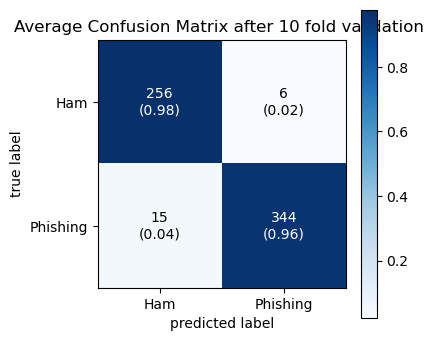

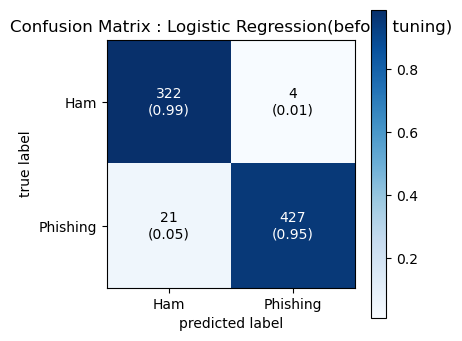

              precision    recall  f1-score   support

           0     0.9388    0.9877    0.9626       326
           1     0.9907    0.9531    0.9716       448

    accuracy                         0.9677       774
   macro avg     0.9647    0.9704    0.9671       774
weighted avg     0.9688    0.9677    0.9678       774

MCC:  0.935
Log Loss:  0.136
f1:  97.156
Balanced Accuracy:  97.043
Accuracy:  96.77
ROC_AUC :  97.043


In [50]:
lr = LogisticRegression()
lr = training_and_cross_validation(lr)
MODEL.append("Logistic Regression(before tuning)")
show_performance_metrics(lr,MODEL[-1])

### SVC



Total Average Accuracy is  97.7713 %


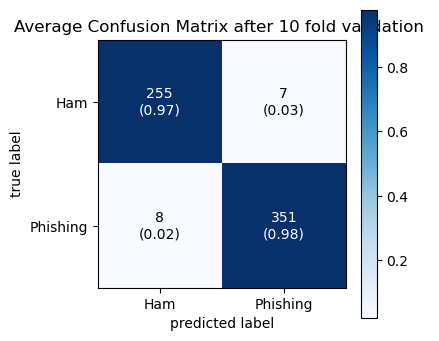

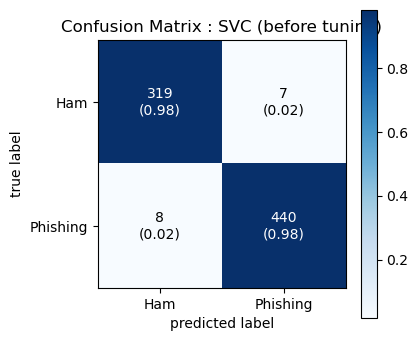

              precision    recall  f1-score   support

           0     0.9755    0.9785    0.9770       326
           1     0.9843    0.9821    0.9832       448

    accuracy                         0.9806       774
   macro avg     0.9799    0.9803    0.9801       774
weighted avg     0.9806    0.9806    0.9806       774

MCC:  0.96
Log Loss:  0.066
f1:  98.324
Balanced Accuracy:  98.034
Accuracy:  98.062
ROC_AUC :  98.034


In [51]:
svc = SVC(probability=True)
svc = training_and_cross_validation(svc)
MODEL.append('SVC (before tuning)')
show_performance_metrics(svc,MODEL[-1])

### Gradient Boosting



Total Average Accuracy is  98.2881 %


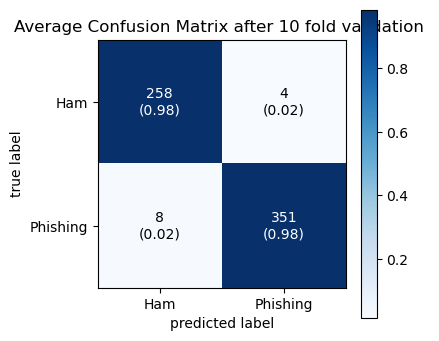

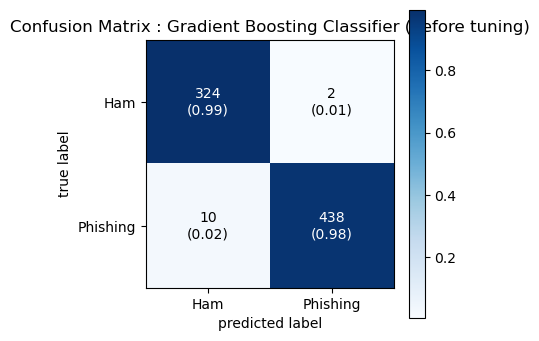

              precision    recall  f1-score   support

           0     0.9701    0.9939    0.9818       326
           1     0.9955    0.9777    0.9865       448

    accuracy                         0.9845       774
   macro avg     0.9828    0.9858    0.9842       774
weighted avg     0.9848    0.9845    0.9845       774

MCC:  0.969
Log Loss:  0.062
f1:  98.649
Balanced Accuracy:  98.577
Accuracy:  98.45
ROC_AUC :  98.577


In [52]:
gbc = GradientBoostingClassifier()
gbc = training_and_cross_validation(gbc)
MODEL.append('Gradient Boosting Classifier (before tuning)')
show_performance_metrics(gbc,MODEL[-1])

### ExtraTrees Classifier



Total Average Accuracy is  97.9971 %


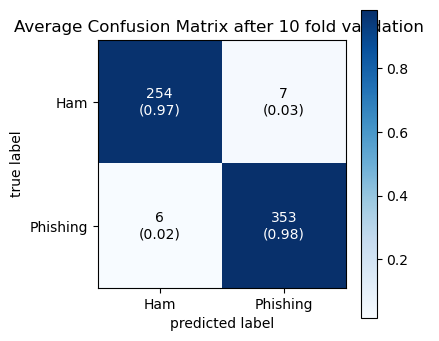

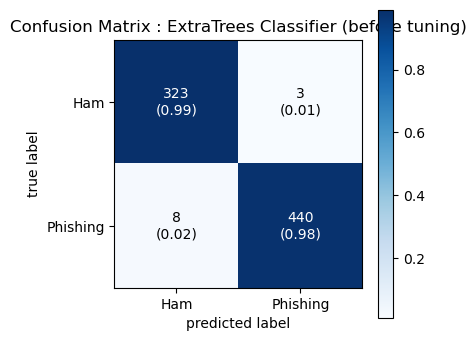

              precision    recall  f1-score   support

           0     0.9758    0.9908    0.9833       326
           1     0.9932    0.9821    0.9877       448

    accuracy                         0.9858       774
   macro avg     0.9845    0.9865    0.9855       774
weighted avg     0.9859    0.9858    0.9858       774

MCC:  0.971
Log Loss:  0.084
f1:  98.765
Balanced Accuracy:  98.647
Accuracy:  98.579
ROC_AUC :  98.647


In [53]:
extc = ExtraTreesClassifier()
extc = training_and_cross_validation(extc)
MODEL.append('ExtraTrees Classifier (before tuning)')
show_performance_metrics(extc,MODEL[-1])

### Random Forest Classifier



Total Average Accuracy is  98.2556 %


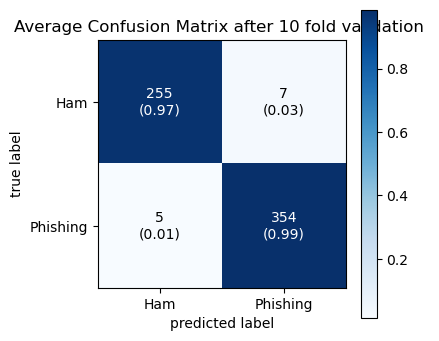

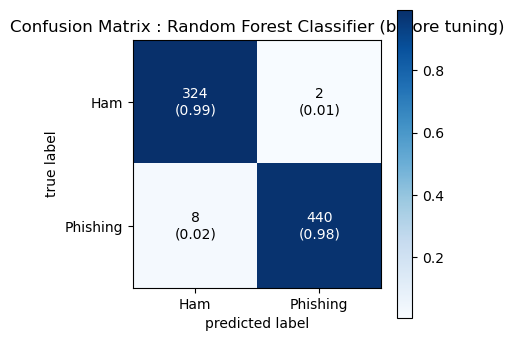

              precision    recall  f1-score   support

           0     0.9759    0.9939    0.9848       326
           1     0.9955    0.9821    0.9888       448

    accuracy                         0.9871       774
   macro avg     0.9857    0.9880    0.9868       774
weighted avg     0.9872    0.9871    0.9871       774

MCC:  0.974
Log Loss:  0.091
f1:  98.876
Balanced Accuracy:  98.8
Accuracy:  98.708
ROC_AUC :  98.8


In [54]:
rf_c = RandomForestClassifier()
rf_c  = training_and_cross_validation(rf_c )
MODEL.append('Random Forest Classifier (before tuning)')
show_performance_metrics(rf_c,MODEL[-1])

## Fine tuning selected models

In [55]:
kfold = 10

### ExtraTrees Classifier

In [56]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="balanced_accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.9844429126604272

ExtraTreesClassifier(max_features=10, min_samples_split=10)


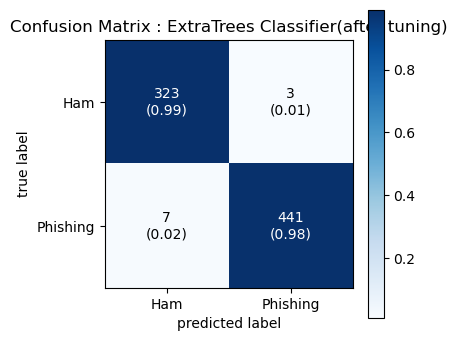

              precision    recall  f1-score   support

           0     0.9788    0.9908    0.9848       326
           1     0.9932    0.9844    0.9888       448

    accuracy                         0.9871       774
   macro avg     0.9860    0.9876    0.9868       774
weighted avg     0.9872    0.9871    0.9871       774

MCC:  0.974
Log Loss:  0.086
f1:  98.879
Balanced Accuracy:  98.759
Accuracy:  98.708
ROC_AUC :  98.759


In [57]:
MODEL.append("ExtraTrees Classifier(after tuning)")
print(ExtC_best)
show_performance_metrics(gsExtC,MODEL[-1],X_test)

### Random Forest Classifier

In [58]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini","entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


0.9844973379267149

RandomForestClassifier(bootstrap=False, max_features=3, min_samples_split=10,
                       n_estimators=300)


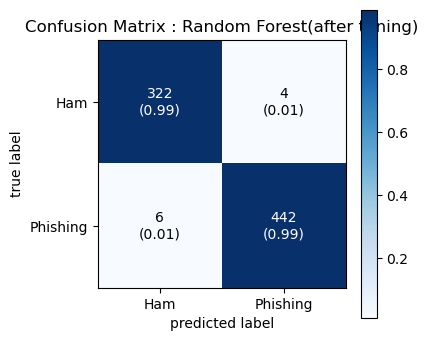

              precision    recall  f1-score   support

           0     0.9817    0.9877    0.9847       326
           1     0.9910    0.9866    0.9888       448

    accuracy                         0.9871       774
   macro avg     0.9864    0.9872    0.9868       774
weighted avg     0.9871    0.9871    0.9871       774

MCC:  0.974
Log Loss:  0.052
f1:  98.881
Balanced Accuracy:  98.717
Accuracy:  98.708
ROC_AUC :  98.717


In [59]:
MODEL.append("Random Forest(after tuning)")
print(RFC_best)
show_performance_metrics(gsRFC,"Random Forest(after tuning)",X_test)

### Gradient Boosting

In [60]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9832101471969935

GradientBoostingClassifier(learning_rate=0.05, loss='deviance', max_depth=8,
                           max_features=0.3, min_samples_leaf=100,
                           n_estimators=300)


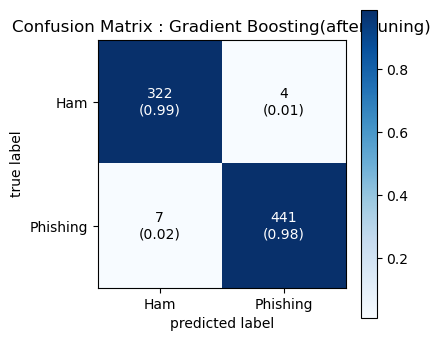

              precision    recall  f1-score   support

           0     0.9787    0.9877    0.9832       326
           1     0.9910    0.9844    0.9877       448

    accuracy                         0.9858       774
   macro avg     0.9849    0.9861    0.9854       774
weighted avg     0.9858    0.9858    0.9858       774

MCC:  0.971
Log Loss:  0.047
f1:  98.768
Balanced Accuracy:  98.605
Accuracy:  98.579
ROC_AUC :  98.605


In [61]:
MODEL.append("Gradient Boosting(after tuning)")
print(GBC_best)
show_performance_metrics(gsGBC,MODEL[-1],X_test)

### SVC

In [62]:


### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 2,3,5,0.5,0.2]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_



Fitting 10 folds for each of 24 candidates, totalling 240 fits


0.9777200125274037

SVC(C=3, gamma=0.1, probability=True)


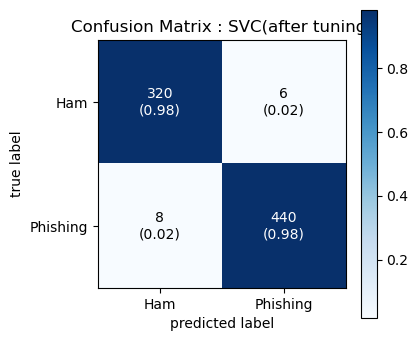

              precision    recall  f1-score   support

           0     0.9756    0.9816    0.9786       326
           1     0.9865    0.9821    0.9843       448

    accuracy                         0.9819       774
   macro avg     0.9811    0.9819    0.9815       774
weighted avg     0.9819    0.9819    0.9819       774

MCC:  0.963
Log Loss:  0.066
f1:  98.434
Balanced Accuracy:  98.187
Accuracy:  98.191
ROC_AUC :  98.187


In [63]:
MODEL.append("SVC(after tuning)")
print(SVMC_best)
show_performance_metrics(gsSVMC,"SVC(after tuning)",X_test)

### Logistic Regression

In [64]:
LR = LogisticRegression()

lr_param_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                 'penalty' : ['l2'],
                 'C' : [1.0, 0.1, 1.5,2.5,5,5.5,0.01]}

gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_



Fitting 10 folds for each of 21 candidates, totalling 210 fits


0.9741750423246514

LogisticRegression(C=0.1, solver='newton-cg')


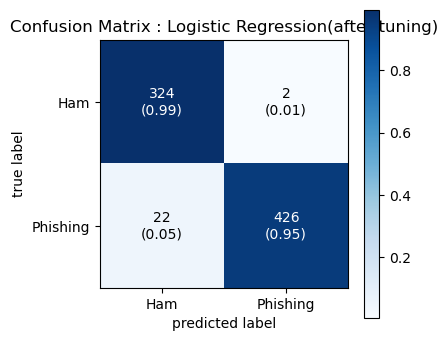

              precision    recall  f1-score   support

           0     0.9364    0.9939    0.9643       326
           1     0.9953    0.9509    0.9726       448

    accuracy                         0.9690       774
   macro avg     0.9659    0.9724    0.9684       774
weighted avg     0.9705    0.9690    0.9691       774

MCC:  0.938
Log Loss:  0.153
f1:  97.26
Balanced Accuracy:  97.238
Accuracy:  96.899
ROC_AUC :  97.238


In [65]:

print(LR_best)
show_performance_metrics(gsLR,"Logistic Regression(after tuning)",X_test)

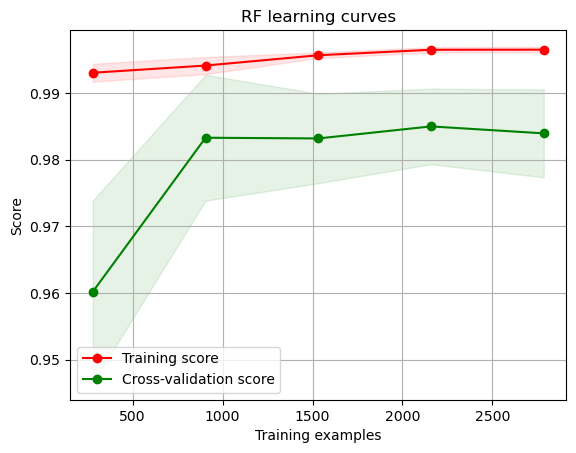

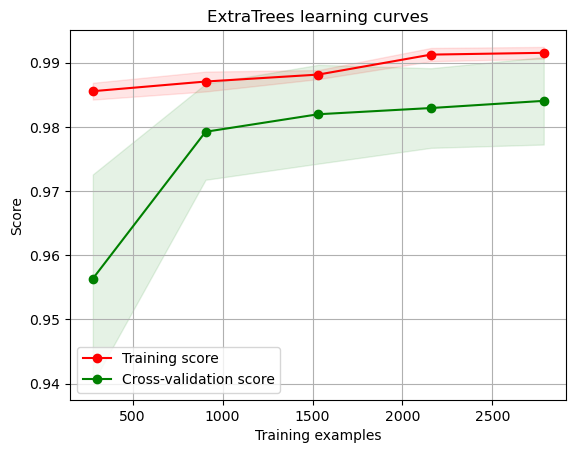

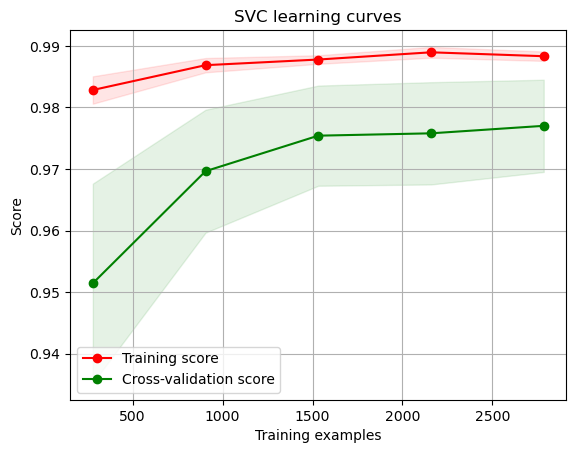

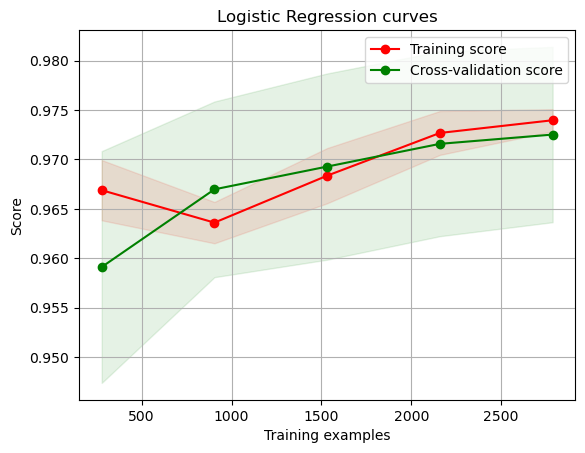

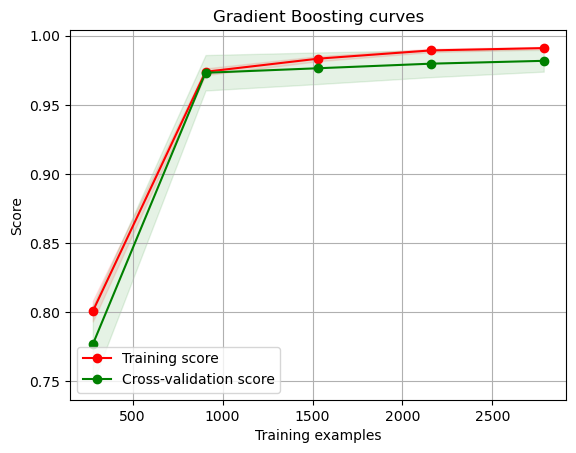

In [66]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='balanced_accuracy', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
kfold = 10
g = plot_learning_curve(gsRFC.best_estimator_,"RF learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"Logistic Regression curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"Gradient Boosting curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(soft_voting_model,"Voting Model learning curves",X_train,Y_train,cv=kfold)


Now, if we try to focus a bit on learning curve it reveals that:
- After a particular training size, SVC balances the bias and variance trade off and the curves are at almost same gap forward to the adequate training size.
- ExtraTrees also performed decent but after a point excess training leads to a slight increase in bias and then resulting underfitting.
- Random Forest also follows almost same trends as SVC, achieving decent balance between bias and variance.
- At last Logistic Regression and GradientBoosting are highly overfitting.<br><br>
So, for voting classifier we will go with three models:
- SVC (C=3, gamma=0.1, probability=True)
- ExtraTrees Classifier (max_features=1, min_samples_split=10, n_estimators=300)
- Random Forest Classifier (bootstrap=False, max_features=3, min_samples_leaf=3,min_samples_split=3)
<br>Above all three have good balanced accuracy and also do well on balancing the bias and variance trade off.

##  Ensemble Model (Voting Classifier)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits


Total Average Accuracy is  98.3525 %


VotingClassifier(estimators=[('Random Forest Model',
                              GridSearchCV(cv=10,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=4,
                                           param_grid={'bootstrap': [False],
                                                       'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [None],
                                                       'max_features': [1, 3,
                                                                        10],
                                                       'min_samples_leaf': [1,
                                                                            3,
                                                                            10],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             10],
                                                       'n_estimators': [100,
                                                                        300]},
                                           scoring='accuracy', verbose=1)),
                             ('ExtraTrees Class...
                                                       'criterion': ['gini'],
                                                       'max_depth': [None],
                                                       'max_features': [1, 3,
                                                                        10],
                                                       'min_samples_leaf': [1,
                                                                            3,
                                                                            10],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             10],
                                                       'n_estimators': [100,
                                                                        300]},
                                           scoring='balanced_accuracy',
                                           verbose=1)),
                             ('SVC',
                              GridSearchCV(cv=10,
                                           estimator=SVC(probability=True),
                                           n_jobs=4,
                                           param_grid={'C': [1, 2, 3, 5, 0.5,
                                                             0.2],
                                                       'gamma': [0.001, 0.01,
                                                                 0.1, 1],
                                                       'kernel': ['rbf']},
                                           scoring='accuracy', verbose=1))])

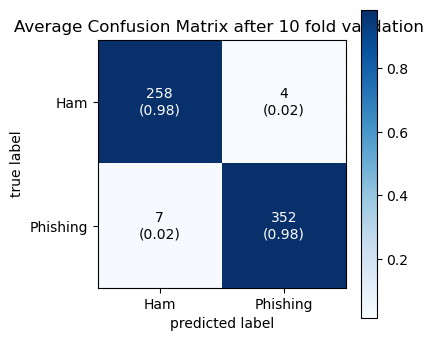

In [67]:
voting_model = VotingClassifier(
    [
        ("Random Forest Model", gsRFC),
        ("ExtraTrees Classifier",gsExtC),
        ("SVC",gsSVMC)
    ]
) 


training_and_cross_validation(voting_model)



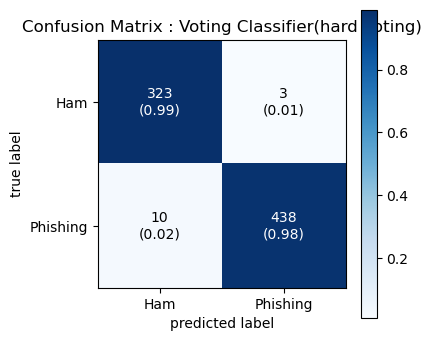

              precision    recall  f1-score   support

           0     0.9700    0.9908    0.9803       326
           1     0.9932    0.9777    0.9854       448

    accuracy                         0.9832       774
   macro avg     0.9816    0.9842    0.9828       774
weighted avg     0.9834    0.9832    0.9832       774

MCC:  0.966
Log Loss:  N/A
f1:  98.538
Balanced Accuracy:  98.424
Accuracy:  98.32
ROC_AUC :  98.424


In [68]:
MODEL.append("Voting Classifier(hard voting)")
show_performance_metrics(voting_model,"Voting Classifier(hard voting)")
   


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits


Total Average Accuracy is  98.288 %


VotingClassifier(estimators=[('Random Forest Model',
                              GridSearchCV(cv=10,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=4,
                                           param_grid={'bootstrap': [False],
                                                       'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [None],
                                                       'max_features': [1, 3,
                                                                        10],
                                                       'min_samples_leaf': [1,
                                                                            3,
                                                                            10],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             10],
                                                       'n_estimators': [100,
                                                                        300]},
                                           scoring='accuracy', verbose=1)),
                             ('ExtraTrees Class...
                                                       'max_depth': [None],
                                                       'max_features': [1, 3,
                                                                        10],
                                                       'min_samples_leaf': [1,
                                                                            3,
                                                                            10],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             10],
                                                       'n_estimators': [100,
                                                                        300]},
                                           scoring='balanced_accuracy',
                                           verbose=1)),
                             ('SVC',
                              GridSearchCV(cv=10,
                                           estimator=SVC(probability=True),
                                           n_jobs=4,
                                           param_grid={'C': [1, 2, 3, 5, 0.5,
                                                             0.2],
                                                       'gamma': [0.001, 0.01,
                                                                 0.1, 1],
                                                       'kernel': ['rbf']},
                                           scoring='accuracy', verbose=1))],
                 voting='soft')

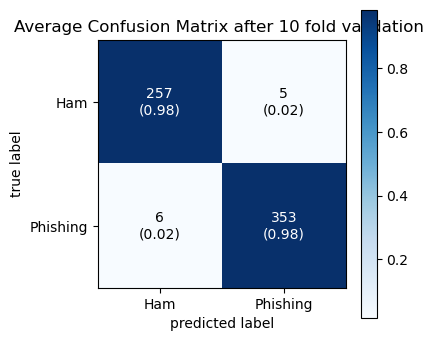

In [69]:
soft_voting_model = VotingClassifier(
    [
        ("Random Forest Model", gsRFC),
        ("ExtraTrees Classifier",gsExtC),
        ("SVC",gsSVMC)
    ],voting="soft",flatten_transform=True
)

training_and_cross_validation(soft_voting_model)



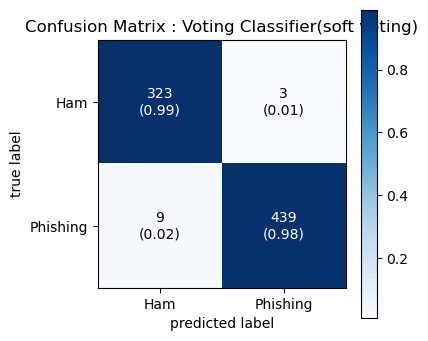

              precision    recall  f1-score   support

           0     0.9729    0.9908    0.9818       326
           1     0.9932    0.9799    0.9865       448

    accuracy                         0.9845       774
   macro avg     0.9831    0.9854    0.9841       774
weighted avg     0.9847    0.9845    0.9845       774

MCC:  0.968
Log Loss:  0.054
f1:  98.652
Balanced Accuracy:  98.535
Accuracy:  98.45
ROC_AUC :  98.535


In [70]:
MODEL.append("Voting Classifier(soft voting)")
show_performance_metrics(soft_voting_model,MODEL[-1])


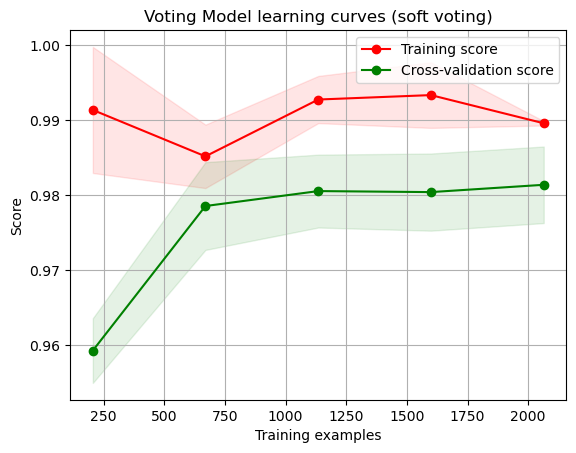

In [71]:
g = plot_learning_curve(soft_voting_model,"Voting Model learning curves (soft voting)",X_train,Y_train,cv=3,n_jobs=-1)

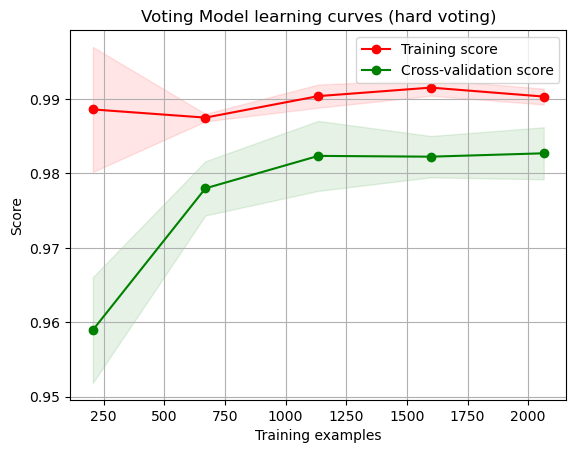

In [72]:
g = plot_learning_curve(voting_model,"Voting Model learning curves (hard voting)",X_train,Y_train,cv=3)

Both voting methods performed almost exactly same. Athough they have slight less accurate, yet they have very good balance in bias and variance trade off. They can be very useful in real world application as they tend not to overfit the training data while minimizing the gap between training and cross validation error. Thus, it could be inferred that they will perform better in real world application.

## Performance Comparisons

In [73]:
performance_comp = []
performance_comp.append(["Model","Accuracy","Balanced Accuracy","Log loss","F1 Score","MCC","ROC_AUC","Report"])
for model in MODEL:
    row = []
    row.append(model)
    row.append(ACCURACY[model])
    row.append(BALANCED_ACCURACY[model])
    row.append(LOG_LOSS[model])
    row.append(F1[model])
    row.append(MCC[model])
    row.append(ROC_AUC[model])
    row.append(REPORT[model])
    performance_comp.append(row)
performance_comp = pd.DataFrame(performance_comp[1:],columns=performance_comp[0])
performance_comp
# performance_comp.to_csv('performance comparision.csv')

,Model,Accuracy,Balanced Accuracy,Log loss,F1 Score,MCC,ROC_AUC,Report
0,Logistic Regression(before tuning),96.770,97.043,0.136,97.156,0.935,97.043,precision recall f1-score ...
1,SVC (before tuning),98.062,98.034,0.066,98.324,0.960,98.034,precision recall f1-score ...
2,Gradient Boosting Classifier (before tuning),98.450,98.577,0.062,98.649,0.969,98.577,precision recall f1-score ...
3,ExtraTrees Classifier (before tuning),98.579,98.647,0.084,98.765,0.971,98.647,precision recall f1-score ...
4,Random Forest Classifier (before tuning),98.708,98.800,0.091,98.876,0.974,98.800,precision recall f1-score ...
5,ExtraTrees Classifier(after tuning),98.708,98.759,0.086,98.879,0.974,98.759,precision recall f1-score ...
6,Random Forest(after tuning),98.708,98.717,0.052,98.881,0.974,98.717,precision recall f1-score ...
7,Gradient Boosting(after tuning),98.579,98.605,0.047,98.768,0.971,98.605,precision recall f1-score ...
8,SVC(after tuning),98.191,98.187,0.066,98.434,0.963,98.187,precision recall f1-score ...
9,Voting Classifier(hard voting),98.320,98.424,N/A,98.538,0.966,98.424,precision recall f1-score ...


In [74]:
import re
import sklearn

import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


y = performance_comp['Balanced Accuracy'].values
x = MODEL
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color =  performance_comp['Balanced Accuracy'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Balanced Accuracy comparison of models',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Balanced Accuracy',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')



In [75]:
import re
import sklearn

import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


y = performance_comp['MCC'].values
x = MODEL
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color =  performance_comp['MCC'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'MCC comparison of models',
    hovermode= 'closest',

    yaxis=dict(
        title= 'MCC',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')



## Conclusions

During the research both ExtraTrees Classifier and Random Forest were really close to each other performance wise. Although balanced accuracy of both the ExtraTrees Classifier and Random Forest are same yet Random Forest has good log loss score in comparison to ExtraTrees.<br><br>
Random Forest came out as the better model to identify the phishing mail considering the selected features than ExtraTrees as it has decent balance of bias and variance. SVC would also be a really good choice in real world as shown in research it smoothly balances the bias and variance tradeoff thus it learns while training still it doesn’t overfit and can perform really good in new data.<br><br>
The bar plot above shows how the models performed in terms of balanced accuracy score. We can see every model has improved the performance after tuning up.

Following inferences are made from the research :
1. Best performing model is hyperparameter tuned Random Forest Classifier with accuracy of 98.469% and log loss of 0.066.and parameters are (bootstrap=False,max_features=3,min_leaf_sample=3,min_sample_split=3)
2. Although Random Forest performed best in our research experiment, SVM and Voting Classifier turns out to be better in balancing bias and variance tradeoff.
3. Logistic Regression and Gradient Boosting tend to overfit so better to avoid or use in a way that can counter the overfitting. For example, we can include them in model stacking or voting classifier and counter the overfit by adjusting the weights.
4. Lastly, it is evident that to have better real world performing model we can go for Voting Classifier. We can have better performance to new test data while sacrificing minimal accuracy.

## Future Work

Feature selection techniques need more improvement to cope with the continuous development of new techniques by the phishers over the time. Therefore, it is recommended to developing a new automated tool in order to extract new features from new raw emails to improve the accuracy of detecting phishing email and to cope with the expanding with phisher techniques.

In [82]:
import joblib

# Save model
joblib.dump(gsRFC, 'RandomForestModel.pkl')

# Load model
model = joblib.load('RandomForestModel.pkl')

# Use the model for prediction
y_pred = model.predict(X_test)

In [ ]:
ExtC = ExtraTreesClassifier()